In [1]:
%tensorflow_version 2.x
%matplotlib inline

In [2]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, concatenate
from tensorflow import test, device
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from keras.utils import to_categorical

In [3]:
import numpy as np
import pandas

After doing the two primary exercises for RNNs, I looked for something else to do with them and I found [this](https://www.kaggle.com/c/nlp-getting-started) dataset on kaggle. It's composed of tweets that use language based around disasters and bad things, but some of them are fake, such as when they are sarcastic or exaggerative. Thus this dataset is for classifying whether a tweet is about an actual disaster or not. Each tweet has 3 types of data: a keyword, which is the main disaster associated word in the tweet; the location given; and the body of the tweet.

In [4]:
data = pandas.read_csv('train.csv')

In [5]:
data.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [91]:
data[2000:2010]

,id,keyword,location,text,target
2000,2875,damage,Unknown,@BradleyBrad47 the saw is fast af and does gre...,0
2001,2877,damage,"Marysville, MI",Let's say a tree falls on your fence. Do you k...,0
2002,2878,damage,"New Haven, Connecticut",@JoeDawg42 TOR for a TOR situation only. Wind ...,1
2003,2879,damage,,@HfxStanfield @beelieveDC @DiscoveryCntr what ...,1
2004,2880,damage,Austin | San Diego,@swb1192 if the NDA is written to damage your ...,0
2005,2881,damage,??? ?? ???????,If Trillion crosses the line a 3rd time he doe...,1
2006,2882,damage,"Pontevedra, Galicia",#NP Metallica - Damage Inc,0
2007,2883,damage,Somewhere in the Canada,Nine inmates charged with causing damage in Ca...,1
2008,2884,damage,London/New York,#pt Cross-sectarian protest. Powerful Shia cle...,1
2009,2885,damage,"261 5th Avenue New York, NY",Does homeowners insurance cover water damage? ...,1


As you can see, these tweets are not at all clean, especially the locations which have wildly varying formatting.

In [6]:
data = data.fillna('')

In [7]:
data_keyword = data['keyword'].to_numpy()
data_location = data['location'].to_numpy()
data_text = data['text'].to_numpy()
data_y = data['target'].to_numpy()

In [8]:
print(data_keyword.shape, data_location.shape, data_text.shape)

(7613,) (7613,) (7613,)


In [9]:
np.concatenate([data_text, data_location, data_keyword])

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ..., '', '', ''], dtype=object)

In [41]:
tkeyword = Tokenizer()
tlocation = Tokenizer()
ttext = Tokenizer()
tkeyword.fit_on_texts(data_keyword)
tlocation.fit_on_texts(data_location)
ttext.fit_on_texts(data_text)
token_keyword = tkeyword.texts_to_sequences(data_keyword)
token_location = tlocation.texts_to_sequences(data_location)
token_text = ttext.texts_to_sequences(data_text)

In [42]:
klengths = [len(keyword) for keyword in token_keyword]
print('Longest keyword: {} Shortest keyword: {}'.format(max(klengths), min(klengths)))
llengths = [len(location) for location in token_location]
print('Longest location: {} Shortest location: {}'.format(max(llengths), min(llengths)))
lengths = [len(text) for text in token_text]
print('Longest text: {} Shortest text: {}'.format(max(lengths), min(lengths)))

Longest keyword: 3 Shortest keyword: 0
Longest location: 12 Shortest location: 0
Longest text: 33 Shortest text: 1


(array([ 190.,  411.,  639.,  915., 1221., 1854., 1456.,  726.,  179.,
          22.]),
 array([ 1. ,  4.2,  7.4, 10.6, 13.8, 17. , 20.2, 23.4, 26.6, 29.8, 33. ]),
 <a list of 10 Patch objects>)

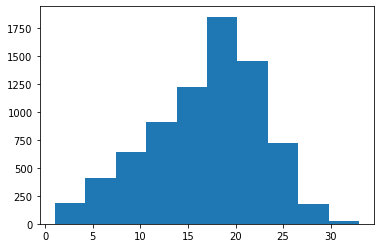

In [43]:
import matplotlib
matplotlib.pyplot.hist(lengths)

In [61]:
keyword_cutoff = 1
location_cutoff = 3
text_cutoff = 24
print('{} keywords out of {} are over {}.'.format(
    sum([1 for klength in klengths if klength > keyword_cutoff]), 
    len(klengths), 
    keyword_cutoff))
print('{} locations out of {} are over {}.'.format(
    sum([1 for llength in llengths if llength > location_cutoff]), 
    len(llengths), 
    location_cutoff))
print('{} texts out of {} are over {}.'.format(
    sum([1 for length in lengths if length > text_cutoff]), 
    len(lengths), 
    text_cutoff))

1165 keywords out of 7613 are over 1.
629 locations out of 7613 are over 3.
610 texts out of 7613 are over 24.


In [45]:
keyword_padded = sequence.pad_sequences(keyword_categorical, maxlen=keyword_cutoff)
location_padded = sequence.pad_sequences(token_location, maxlen=location_cutoff)
text_padded = sequence.pad_sequences(token_text, maxlen=text_cutoff)

In [69]:
keyword_categorical = to_categorical(keyword_padded)

In [46]:
data_y

array([1, 1, 1, ..., 1, 1, 1])

In [70]:
keyword_train, keyword_test, location_train, location_test, text_train, text_test, y_train, y_test = train_test_split(keyword_categorical, location_padded, text_padded, data_y, test_size=0.3, random_state=42)

In [71]:
keyword_train.shape

(5329, 239)

Because of these three completely different types of data, I decided to try making a mixed data ML model for the first time. For this I had to learn keras's functional API. For analyzing the keywords, I decided to go with a straightforward one hot encoding because I reasoned that what we cared about was the presence of the word. It's relations to other words could be analyzed in the body of the tweet. For the locations, I did a super small embedding layer to learn more about the meaning of the locations. I originally hoped to simply do a dense layer on top of the embedding but that led to shape problems so I settled for a basic LSTM. Lastly, for the body of the tweet I did the real RNN with two layers of LSTM on top of a large embedding layer. Then I concatenated them together and did one final dense layer.

In [72]:
# pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
input_keyword = Input(shape=(239, ))
input_location = Input(shape=(3, ))
input_text = Input(shape=(24, ))

In [73]:
m_keyword = Dense(1, activation='sigmoid')(input_keyword)
m_keyword = Model(inputs=input_keyword, outputs=m_keyword)

In [74]:
m_location = Embedding(input_dim=len(tlocation.word_index)+1, output_dim=6, input_length=location_cutoff)(input_location)
m_location = LSTM(units=4)(m_location)
m_location = Dense(8, activation='tanh')(m_location)
m_location = Model(inputs=input_location, outputs=m_location)

In [75]:
m_text = Embedding(input_dim=len(ttext.word_index)+1, output_dim=80, input_length=text_cutoff)(input_text)
m_text = LSTM(units=24, return_sequences=True)(m_text)
m_text = LSTM(units=24)(m_text)
m_text = Model(inputs=input_text, outputs=m_text)

In [76]:
combined = concatenate([m_keyword.output, m_location.output, m_text.output])

In [77]:
m_final = Dense(20, activation="relu")(combined)
m_final = Dense(1, activation="sigmoid")(m_final)
m_final = Model(inputs=[m_keyword.input, m_location.input, m_text.input], outputs=m_final)

Through my research I also found this cool function that makes a diagram of the model!

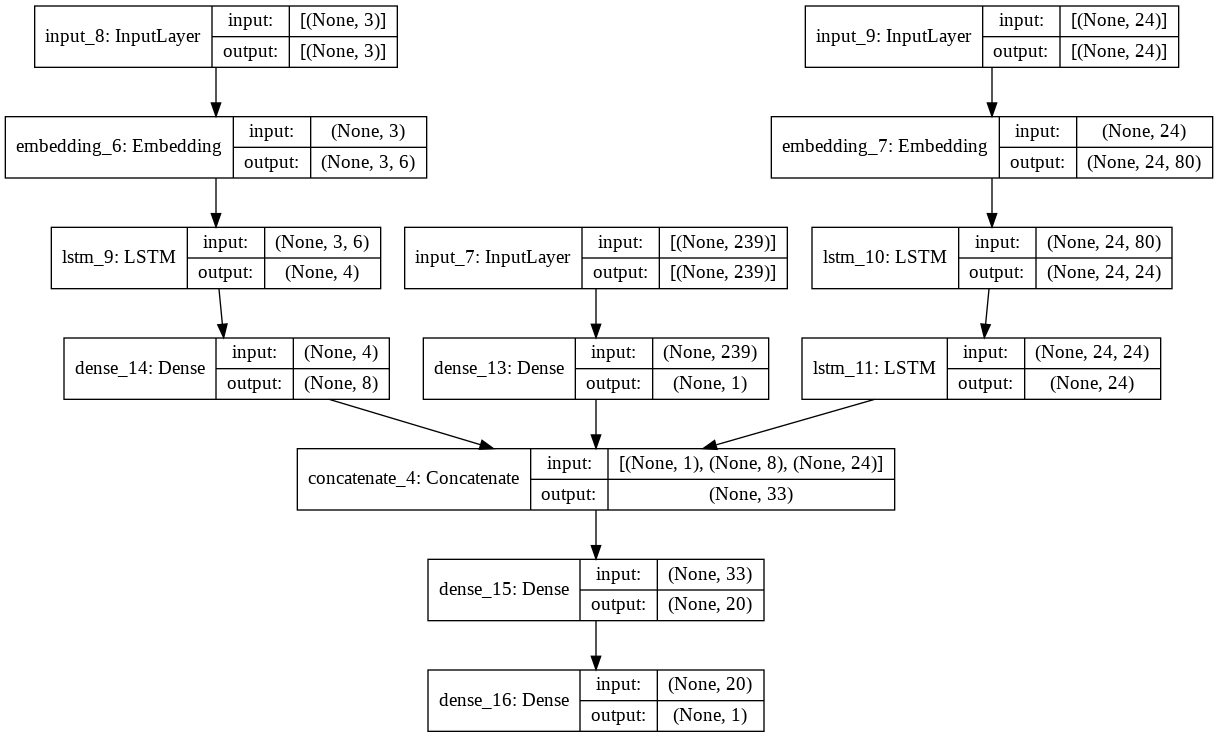

In [78]:
from keras.utils import plot_model
plot_model(m_final, show_shapes=True)

In [79]:
m_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [80]:
# Train using GPU acceleration
# (see https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ)
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

with device('/device:GPU:0'):
  print('Epoch 1')
  m_final.fit([keyword_train, location_train, text_train], y_train, epochs=1, batch_size=64)

Epoch 1
84/84 [==============================] - 7s 27ms/step - loss: 0.6432 - binary_accuracy: 0.6275


Surprisingly, after the first epoch, the model had a much lower accuracy on the training data than on the test data, where it had 80%.

In [82]:
with device('/device:GPU:0'):
  tweet_scores = m_final.evaluate([keyword_test, location_test, text_test], y_test)
  print('after epoch 1')
  print('loss: {} accuracy: {}'.format(*tweet_scores))

72/72 [==============================] - 0s 5ms/step - loss: 0.4616 - binary_accuracy: 0.8052
after epoch 1
loss: 0.4616228938102722 accuracy: 0.8051663637161255


In [83]:
with device('/device:GPU:0'):
  print('Epoch 2')
  m_final.fit([keyword_train, location_train, text_train], y_train, epochs=1, batch_size=64)

Epoch 2
84/84 [==============================] - 2s 28ms/step - loss: 0.3143 - binary_accuracy: 0.8767


In the second round the training data accuracy jumped significantly, as it did every round after, but the test data accuracy stayed stagnant.

In [84]:
with device('/device:GPU:0'):
  tweet_scores = m_final.evaluate([keyword_test, location_test, text_test], y_test)
  print('after epoch 2')
  print('loss: {} accuracy: {}'.format(*tweet_scores))

72/72 [==============================] - 0s 5ms/step - loss: 0.4569 - binary_accuracy: 0.7990
after epoch 2
loss: 0.456919401884079 accuracy: 0.7990368008613586


In [85]:
with device('/device:GPU:0'):
  print('Epoch 3')
  m_final.fit([keyword_train, location_train, text_train], y_train, epochs=1, batch_size=64)

Epoch 3
84/84 [==============================] - 2s 27ms/step - loss: 0.1608 - binary_accuracy: 0.9445


In [86]:
with device('/device:GPU:0'):
  tweet_scores = m_final.evaluate([keyword_test, location_test, text_test], y_test)
  print('after epoch 3')
  print('loss: {} accuracy: {}'.format(*tweet_scores))

72/72 [==============================] - 0s 5ms/step - loss: 0.5685 - binary_accuracy: 0.7723
after epoch 3
loss: 0.5684566497802734 accuracy: 0.7723292708396912


In epoch 3 we begin to see signs of overfitting, with a super high training data accuracy, but a declining testing data accuracy.

In [87]:
with device('/device:GPU:0'):
  print('Epoch 4')
  m_final.fit([keyword_train, location_train, text_train], y_train, epochs=1, batch_size=64)

Epoch 4
84/84 [==============================] - 2s 27ms/step - loss: 0.0878 - binary_accuracy: 0.9728


In [88]:
with device('/device:GPU:0'):
  tweet_scores = m_final.evaluate([keyword_test, location_test, text_test], y_test)
  print('after epoch 4')
  print('loss: {} accuracy: {}'.format(*tweet_scores))

72/72 [==============================] - 0s 5ms/step - loss: 0.6664 - binary_accuracy: 0.7469
after epoch 4
loss: 0.6663629412651062 accuracy: 0.7469351887702942


In [93]:
with device('/device:GPU:0'):
  print('Epoch 5')
  m_final.fit([keyword_train, location_train, text_train], y_train, epochs=1, batch_size=64)

Epoch 5
84/84 [==============================] - 2s 28ms/step - loss: 0.0476 - binary_accuracy: 0.9857


In [94]:
with device('/device:GPU:0'):
  tweet_scores = m_final.evaluate([keyword_test, location_test, text_test], y_test)
  print('after epoch 5')
  print('loss: {} accuracy: {}'.format(*tweet_scores))

72/72 [==============================] - 0s 5ms/step - loss: 0.7854 - binary_accuracy: 0.7535
after epoch 5
loss: 0.7853765487670898 accuracy: 0.753502607345581


In [95]:
with device('/device:GPU:0'):
  print('Epoch 6')
  m_final.fit([keyword_train, location_train, text_train], y_train, epochs=1, batch_size=64)

Epoch 6
84/84 [==============================] - 2s 28ms/step - loss: 0.0285 - binary_accuracy: 0.9921


In [96]:
with device('/device:GPU:0'):
  tweet_scores = m_final.evaluate([keyword_test, location_test, text_test], y_test)
  print('after epoch 6')
  print('loss: {} accuracy: {}'.format(*tweet_scores))

72/72 [==============================] - 0s 5ms/step - loss: 0.8121 - binary_accuracy: 0.7469
after epoch 6
loss: 0.8121131062507629 accuracy: 0.7469351887702942


In [97]:
with device('/device:GPU:0'):
  print('Epoch 7')
  m_final.fit([keyword_train, location_train, text_train], y_train, epochs=1, batch_size=64)

Epoch 7
84/84 [==============================] - 2s 28ms/step - loss: 0.0211 - binary_accuracy: 0.9938


In [98]:
with device('/device:GPU:0'):
  tweet_scores = m_final.evaluate([keyword_test, location_test, text_test], y_test)
  print('after epoch 7')
  print('loss: {} accuracy: {}'.format(*tweet_scores))

72/72 [==============================] - 0s 5ms/step - loss: 0.8220 - binary_accuracy: 0.7474
after epoch 7
loss: 0.8219590783119202 accuracy: 0.7473730444908142


In the subsequent epochs, the testing data accuracy declined more, finally settling around 75%, while the training data accuracy climbed to nearly perfect. I think this overfitting shows that the model was much larger than necessary.

In [92]:
m_final.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 3, 6)         19950       input_8[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 24, 80)       1816080     input_9[0][0]                    
___________________________________________________________________________________________

For the second try, I decided to eliminate the location variable entirely because I supposed that physical location was not really a factor in whether something was a disaster, and when it was obviously sarcastic then the tweet would be as well. For the keyword, I also changed the activation to relu.

In [103]:
m_keyword2 = Dense(1, activation='relu')(input_keyword)
m_keyword2 = Model(inputs=input_keyword, outputs=m_keyword2)

In [104]:
combined2 = concatenate([m_keyword2.output, m_text.output])

In [105]:
m_final2 = Dense(20, activation="relu")(combined2)
m_final2 = Dense(1, activation="sigmoid")(m_final2)
m_final2 = Model(inputs=[m_keyword2.input, m_text.input], outputs=m_final2)

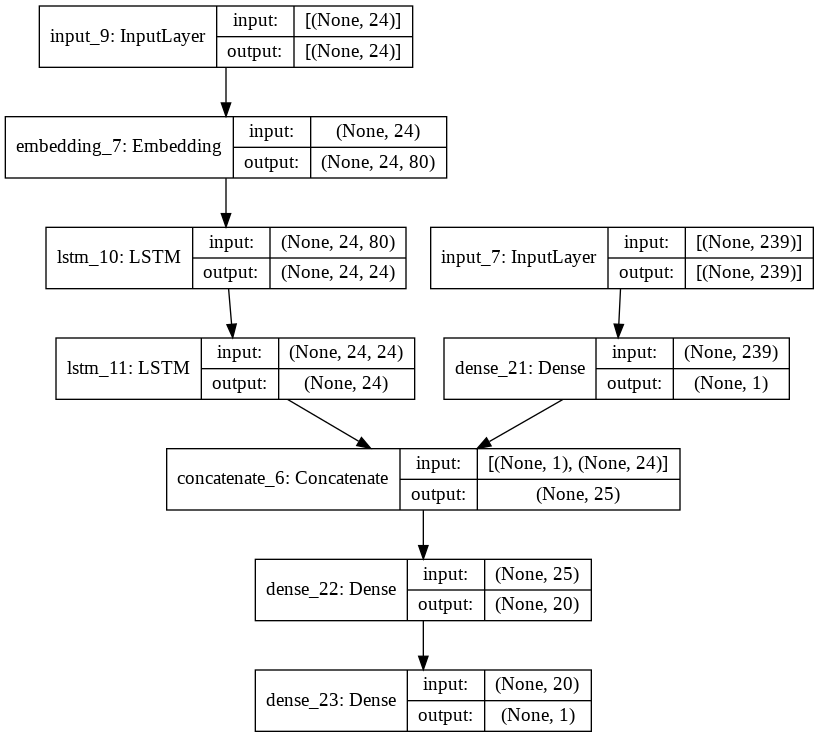

In [106]:
from keras.utils import plot_model
plot_model(m_final2, show_shapes=True)

In [112]:
m_final2.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 24, 80)       1816080     input_9[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 239)]        0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 24, 24)       10080       embedding_7[0][0]                
___________________________________________________________________________________________

In [107]:
m_final2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [108]:
# Train using GPU acceleration
# (see https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ)
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

with device('/device:GPU:0'):
  print('Epoch 1')
  m_final2.fit([keyword_train, text_train], y_train, epochs=1, batch_size=64)

Epoch 1
84/84 [==============================] - 5s 24ms/step - loss: 0.4717 - binary_accuracy: 0.8049


In [109]:
with device('/device:GPU:0'):
  tweet_scores = m_final2.evaluate([keyword_test, text_test], y_test)
  print('after epoch 1')
  print('loss: {} accuracy: {}'.format(*tweet_scores))

72/72 [==============================] - 1s 4ms/step - loss: 0.6428 - binary_accuracy: 0.7377
after epoch 1
loss: 0.6427866220474243 accuracy: 0.7377408146858215


In [110]:
with device('/device:GPU:0'):
  print('Epoch 2')
  m_final2.fit([keyword_train, text_train], y_train, epochs=1, batch_size=64)

Epoch 2
84/84 [==============================] - 2s 25ms/step - loss: 0.0458 - binary_accuracy: 0.9901


In [111]:
with device('/device:GPU:0'):
  tweet_scores = m_final2.evaluate([keyword_test, text_test], y_test)
  print('after epoch 2')
  print('loss: {} accuracy: {}'.format(*tweet_scores))

72/72 [==============================] - 0s 4ms/step - loss: 0.7717 - binary_accuracy: 0.7588
after epoch 2
loss: 0.7717095017433167 accuracy: 0.7587565779685974


Once again I was taken aback, as this model overfit an insane amount by the second epoch, and both training and test accuracies were at the same place where the first model plateaued. Oddly, when the model had a lower training accuracy in the first round, the test accuracy was not as high as in the first model. Overall, this was a good learning experience in a lot of areas.